Generating synthetic exoplanet light curves...
Generating synthetic non-exoplanet light curves...
Generated 500 light curves (100 exoplanets, 400 non-exoplanets).
Preprocessing and extracting features...
Generated 500 light curves (100 exoplanets, 400 non-exoplanets).
Preprocessing and extracting features...
Feature extraction complete.
Features DataFrame shape: (500, 108)

Training Random Forest Classifier...
Model training complete.

--- Model Evaluation ---
Accuracy: 0.9900
Precision: 1.0000
Recall: 0.9500
F1-score: 0.9744
ROC AUC: 0.9991
Feature extraction complete.
Features DataFrame shape: (500, 108)

Training Random Forest Classifier...
Model training complete.

--- Model Evaluation ---
Accuracy: 0.9900
Precision: 1.0000
Recall: 0.9500
F1-score: 0.9744
ROC AUC: 0.9991


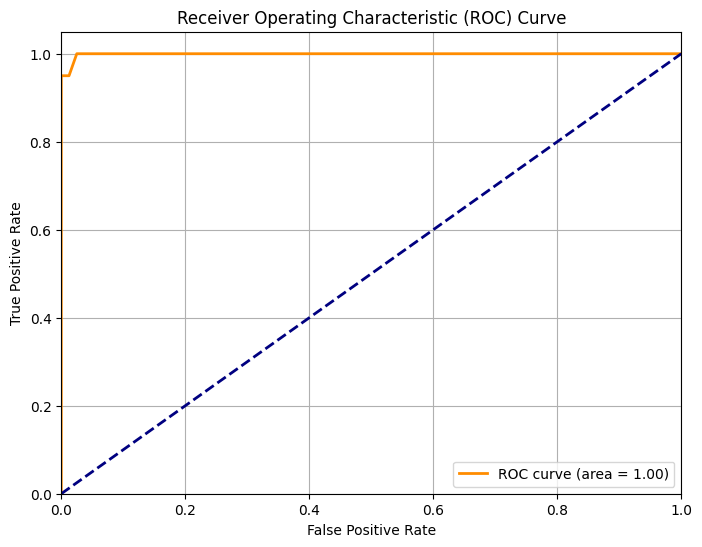

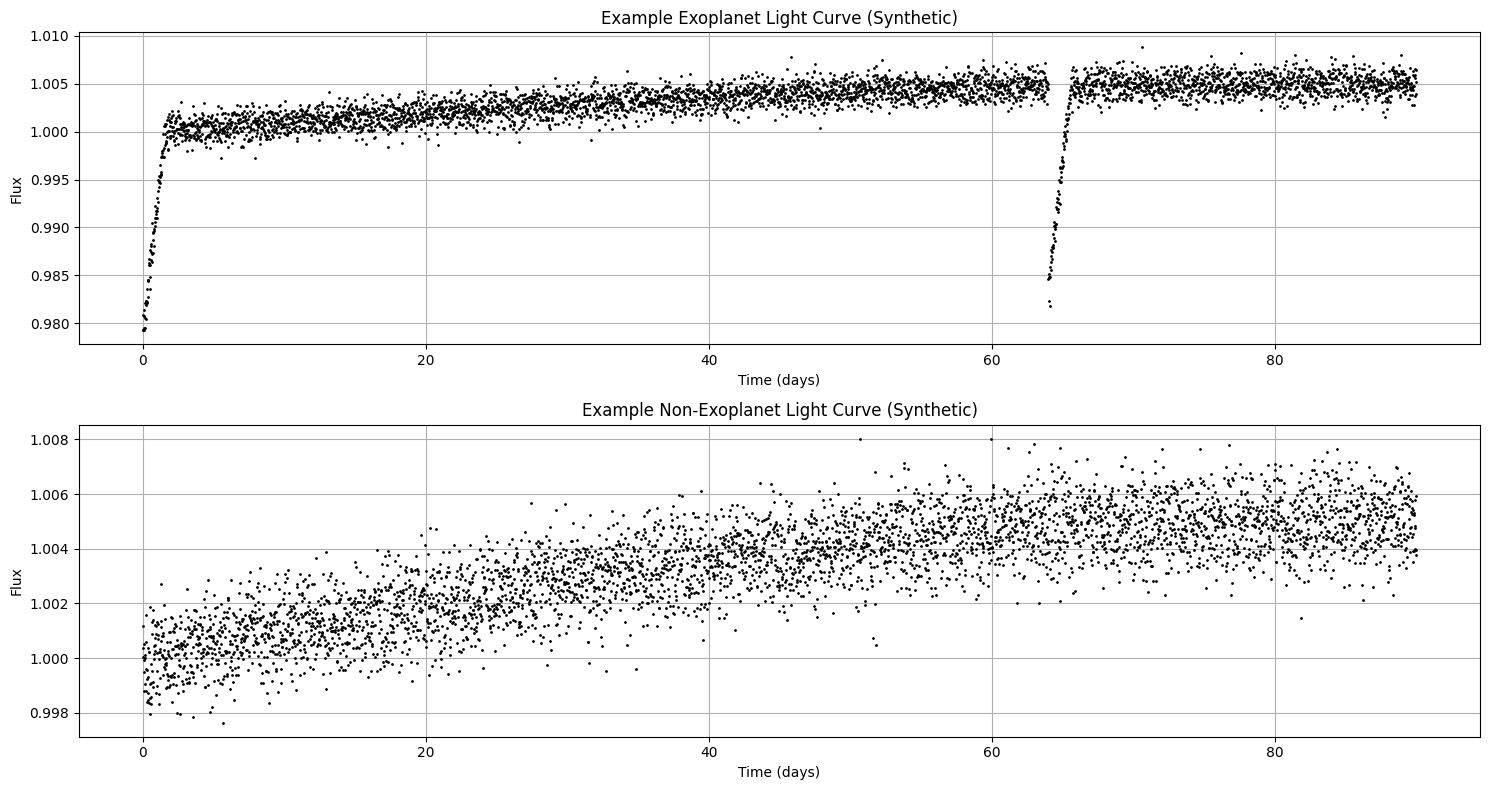

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lightkurve import LightCurve
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from scipy.signal import savgol_filter
import warnings
warnings.filterwarnings('ignore')

# --- 1. Data Simulation (instead of direct download for simplicity) ---
# In a real project, you would download data from NASA Exoplanet Archive using lightkurve.
# Example:
# import lightkurve as lk
# search_result = lk.search_lightcurve('KIC 8462852', author='Kepler') # A famous star, not an exoplanet host
# lc = search_result.download().remove_outliers()

def generate_synthetic_light_curve(time, is_exoplanet=False, period=None):
    """
    Generates a synthetic light curve with optional transit.
    """
    # Baseline stellar flux (with some variability/noise)
    flux = np.random.normal(loc=1.0, scale=0.001, size=len(time))
    flux += 0.005 * np.sin(time / 50) # Long-term stellar variability

    if is_exoplanet:
        if period is None:
            period = np.random.uniform(10, 100) # Random period for transit
        transit_duration = period * 0.05 # 5% of period
        transit_depth = np.random.uniform(0.005, 0.02) # 0.5% to 2% depth

        # Simulate a few transits within the observation window
        for t0 in np.arange(time[0], time[-1] + period, period):
            # Find points within a transit window
            in_transit = (time % period >= (t0 % period) - transit_duration / 2) & \
                         (time % period <= (t0 % period) + transit_duration / 2)

            # Simple box-shaped transit for demonstration
            flux[in_transit] -= transit_depth * (
                1 - np.abs( (time[in_transit] % period - (t0 % period)) / (transit_duration / 2) )
            )

    return LightCurve(time=time, flux=flux)

# Generate a time array (e.g., 90 days of observations, 30-min cadence)
time_base = np.arange(0, 90, 0.02)

num_exoplanets = 100
num_non_exoplanets = 400
light_curves = []
labels = [] # 1 for exoplanet, 0 for non-exoplanet

# Generate exoplanet light curves
print("Generating synthetic exoplanet light curves...")
for _ in range(num_exoplanets):
    lc = generate_synthetic_light_curve(time_base, is_exoplanet=True)
    light_curves.append(lc)
    labels.append(1)

# Generate non-exoplanet light curves (just noisy stars)
print("Generating synthetic non-exoplanet light curves...")
for _ in range(num_non_exoplanets):
    lc = generate_synthetic_light_curve(time_base, is_exoplanet=False)
    light_curves.append(lc)
    labels.append(0)

print(f"Generated {len(light_curves)} light curves ({sum(labels)} exoplanets, {len(labels) - sum(labels)} non-exoplanets).")

# --- 2. Preprocessing & Feature Engineering ---
# This is a critical step. For light curves, typical steps include:
# - Normalization
# - Trend removal (e.g., Savitzky-Golay filter, `lightkurve.flatten()`)
# - Period folding (if a period is known/estimated)
# - Feature extraction

def preprocess_and_feature_engineer(lc, period=None):
    """
    Preprocesses a light curve and extracts features.
    For simplicity, we'll use basic statistical features and a folded curve.
    In a real scenario, `lightkurve`'s periodograms and flatten methods would be used.
    """
    # Remove NaN values if any
    lc = lc.remove_nans()

    # Simple normalization
    normalized_flux = lc.flux / np.median(lc.flux)

    # Basic trend removal (Savitzky-Golay filter)
    # window_length must be odd and less than the size of flux
    window_len = min(len(normalized_flux) - 1 if len(normalized_flux) % 2 == 0 else len(normalized_flux), 51)
    if window_len < 3: # Handle very short LCs
        flattened_flux = normalized_flux
    else:
        flattened_flux = normalized_flux - savgol_filter(normalized_flux, window_length=window_len, polyorder=3) + 1


    # Feature Extraction (simple statistics from the light curve)
    features = {
        'std_dev_flux': np.std(flattened_flux),
        'median_flux': np.median(flattened_flux),
        'min_flux': np.min(flattened_flux),
        'max_flux': np.max(flattened_flux),
        'percentile_10': np.percentile(flattened_flux, 10),
        'percentile_90': np.percentile(flattened_flux, 90),
        'skewness_flux': pd.Series(flattened_flux).skew(),
        'kurtosis_flux': pd.Series(flattened_flux).kurtosis()
    }

    # If period is provided, fold the light curve and add folded features
    folded_lc_features = np.zeros(100) # Placeholder for folded curve shape
    if period is not None:
        try:
            folded_lc = LightCurve(time=lc.time, flux=flattened_flux).fold(period=period, wrap_phase=0.5)
            # Bin the folded light curve to a fixed size for consistent features
            bins, _ = np.histogram(folded_lc.time.value, bins=100, weights=folded_lc.flux.value)
            counts, _ = np.histogram(folded_lc.time.value, bins=100)
            # Avoid division by zero
            folded_lc_features = np.divide(bins, counts, out=np.zeros_like(bins), where=counts!=0)
        except Exception as e:
            print(f"Warning: Could not fold light curve with period {period}: {e}")
            # If folding fails, use zeros for folded features
    
    # Append folded curve features (e.g., as part of a flattened array)
    for i, val in enumerate(folded_lc_features):
        features[f'folded_bin_{i}'] = val

    return pd.Series(features)

all_features = []
print("Preprocessing and extracting features...")
for i, lc in enumerate(light_curves):
    # For a real project, you'd try to estimate the period using Lomb-Scargle periodogram
    # For now, we'll either use a known period for synthetic exoplanets, or try a default.
    # A more sophisticated approach would be to iterate over likely periods.
    if labels[i] == 1: # If it's a synthetic exoplanet, use its period for folding
        # This is cheating for synthetic data; in real data, you'd find it with a periodogram
        period_guess = np.random.uniform(10, 100) # A rough guess for synthetic
    else:
        period_guess = 50 # A generic period for non-exoplanets (or run periodogram)

    features = preprocess_and_feature_engineer(lc, period=period_guess)
    all_features.append(features)

features_df = pd.DataFrame(all_features).fillna(0) # Fill any potential NaNs from feature extraction
print("Feature extraction complete.")
print(f"Features DataFrame shape: {features_df.shape}")

# --- 3. Model Training (Random Forest Classifier) ---
X = features_df
y = np.array(labels)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining Random Forest Classifier...")
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model.fit(X_train, y_train)
print("Model training complete.")

# --- 4. Evaluation ---
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] # Probability of being an exoplanet

print("\n--- Model Evaluation ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob):.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_score(y_test, y_prob):.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# --- Visualization of some synthetic LCs ---
plt.figure(figsize=(15, 8))
plt.subplot(2, 1, 1)
lc_exoplanet = light_curves[np.where(np.array(labels) == 1)[0][0]]
plt.plot(lc_exoplanet.time.value, lc_exoplanet.flux.value, '.k', markersize=2)
plt.title("Example Exoplanet Light Curve (Synthetic)")
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.grid(True)

plt.subplot(2, 1, 2)
lc_non_exoplanet = light_curves[np.where(np.array(labels) == 0)[0][0]]
plt.plot(lc_non_exoplanet.time.value, lc_non_exoplanet.flux.value, '.k', markersize=2)
plt.title("Example Non-Exoplanet Light Curve (Synthetic)")
plt.xlabel("Time (days)")
plt.ylabel("Flux")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Optional: Deep Learning approach placeholder (conceptual) ---
# For a deep learning approach, you'd feed the raw (or slightly processed)
# light curve arrays directly into a 1D CNN.

# Example of how data would be structured for a 1D CNN:
# X_cnn = np.array([lc.flux.value for lc in light_curves])
# X_cnn = X_cnn.reshape(X_cnn.shape[0], X_cnn.shape[1], 1) # Add channel dimension
# This would then be fed into a Keras/TensorFlow model:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
# model_cnn = Sequential([
#     Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(X_cnn.shape[1], 1)),
#     MaxPooling1D(pool_size=2),
#     Conv1D(filters=64, kernel_size=5, activation='relu'),
#     MaxPooling1D(pool_size=2),
#     Flatten(),
#     Dense(100, activation='relu'),
#     Dense(1, activation='sigmoid')
# ])
# model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model_cnn.fit(X_cnn_train, y_train, epochs=10, batch_size=32, validation_data=(X_cnn_test, y_test))

In [11]:
from joblib import dump

# Save the trained model to a file
dump(model, '/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/backend/exoplanet_model.joblib')


['/Users/aditya/Desktop/Hackathon/A-World-Away-Hunting-for-Exoplanets-with-AI/backend/exoplanet_model.joblib']